
=== Example 1: dependent vs independent normals ===
Sample corr (indep) : -0.000
Sample corr (joint) : 0.800
E[X1 X2] indep  est=-0.000, true=0.000
E[X1 X2] joint est=0.799, true=0.800


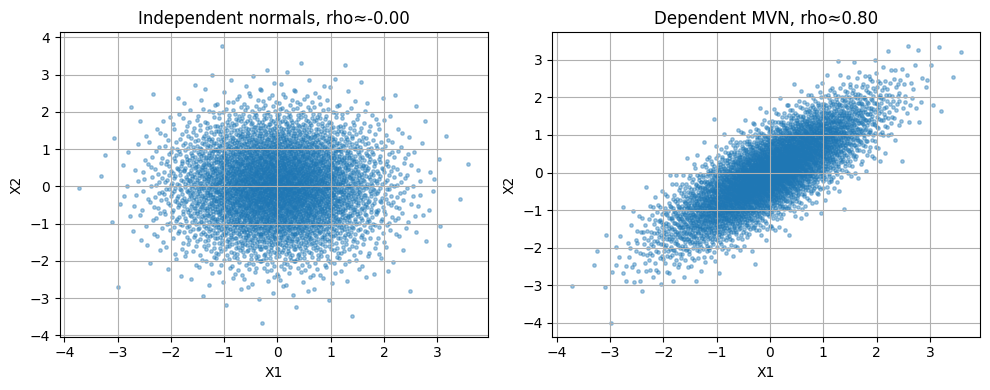

Saved figure: demos\figures\scipywrapper_dependence_custom\fig01_mvn_indep_vs_dep.png

=== Example 2: zero inflated exponential + uniform ===
Target P(X=0)              : 0.400
Empirical P(X=0)           : 0.400
Empirical corr(X, Y)       : 0.461


C:\Users\Owner\Downloads\QMCSoftware\qmcpy\true_measure\scipy_wrapper.py:216: UserWarning: SciPyWrapper joint distribution has no 'logpdf'. Weights will be treated as 1.
  warnings.warn(


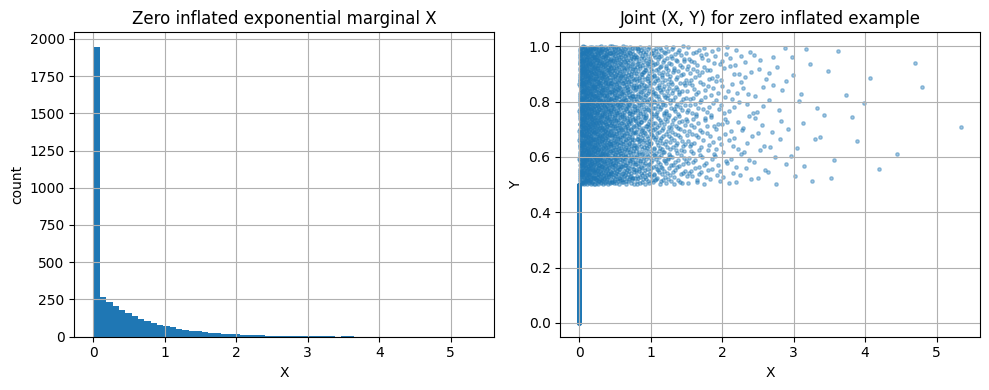

Saved figure: demos\figures\scipywrapper_dependence_custom\fig02_zero_inflated_joint.png

=== Example 3: acceptance rejection, MC vs QMC ===
corr(X, Y) MC  : 0.500
corr(X, Y) QMC : 0.501
E[X Y] MC  : est=0.2449, true=0.2500
E[X Y] QMC : est=0.2505, true=0.2500


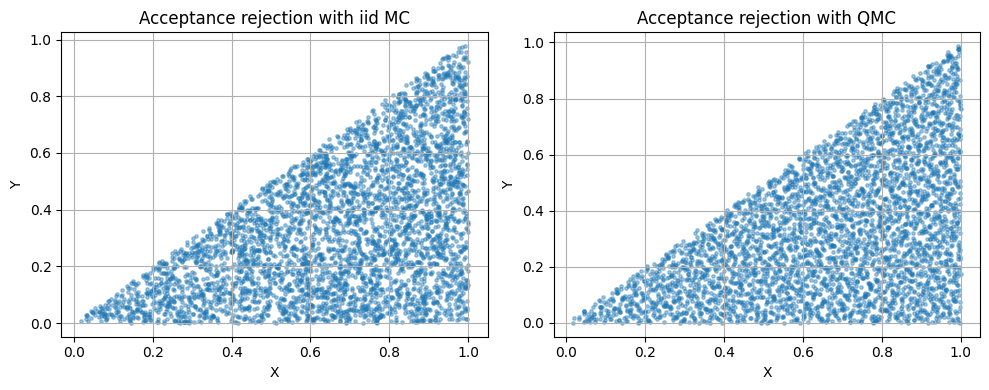

Saved figure: demos\figures\scipywrapper_dependence_custom\fig03_accept_reject_mc_vs_qmc.png

=== Example 4: custom triangular user marginal ===
Sample mean of custom triangular: -0.133
Sample min, max                 : -0.993, 0.976


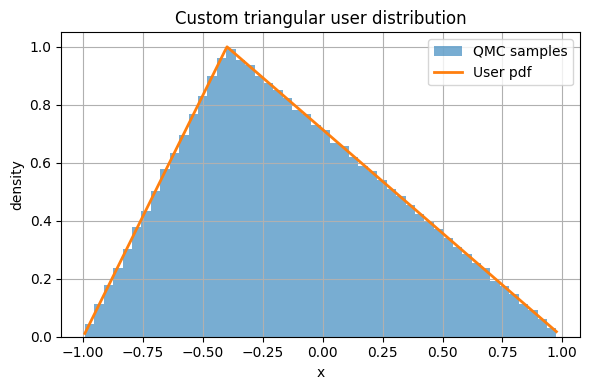

Saved figure: demos\figures\scipywrapper_dependence_custom\fig04_custom_triangular_marginal.png

=== Example 5: intentionally broken custom distribution ===
Constructing SciPyWrapper with a bad custom distribution...
Example samples from bad distribution: [0.99779416 0.30984091 0.43378429 0.77064796]


C:\Users\Owner\Downloads\QMCSoftware\qmcpy\true_measure\scipy_wrapper.py:316: UserWarning: Custom distribution ppf appears non increasing on 0.01..0.99.
  warnings.warn(
C:\Users\Owner\Downloads\QMCSoftware\qmcpy\true_measure\scipy_wrapper.py:345: UserWarning: Custom distribution pdf looks poorly normalised: integral ≈ -0.000 on 0.01..0.99.
  warnings.warn(


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path

from qmcpy.discrete_distribution import DigitalNetB2
from qmcpy.true_measure import SciPyWrapper
from qmcpy.util import ParameterError, DimensionError

# I like having a consistent look across all plots.
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

# Folder where all figures for the blog will be saved.
FIG_DIR = Path("demos") / "figures" / "scipywrapper_dependence_custom"
FIG_DIR.mkdir(parents=True, exist_ok=True)


# ======================================================================
# 1. Custom distributions that behave like SciPy ones
# ======================================================================

class TriangularUserDistribution:
    """
    Triangular user distribution that mirrors scipy.stats.triang.

    Support: [loc, loc + scale]
    Mode   : loc + c * scale, where 0 < c < 1.

    It only provides ppf and pdf. That is enough for SciPyWrapper to use
    it as a custom marginal.
    """

    def __init__(self, c=0.5, loc=0.0, scale=1.0):
        c = float(c)
        loc = float(loc)
        scale = float(scale)

        if not (0.0 < c < 1.0):
            raise ParameterError("c must lie strictly between 0 and 1.")
        if scale <= 0.0:
            raise ParameterError("scale must be positive.")

        self.c = c
        self.loc = loc
        self.scale = scale

        self._a = loc
        self._b = loc + scale
        self._m = loc + c * scale

    def pdf(self, x):
        """
        Density of the triangular distribution.
        """
        x = np.asarray(x, dtype=float)
        a, m, b = self._a, self._m, self._b
        out = np.zeros_like(x, dtype=float)

        left = (x >= a) & (x < m)
        right = (x >= m) & (x <= b)

        # Rising edge.
        out[left] = 2.0 * (x[left] - a) / ((b - a) * (m - a))
        # Falling edge.
        out[right] = 2.0 * (b - x[right]) / ((b - a) * (b - m))
        return out

    def ppf(self, u):
        """
        Inverse CDF used to map u in (0,1) to x in [a, b].
        """
        u = np.asarray(u, dtype=float)
        a, m, b = self._a, self._m, self._b

        Fm = (m - a) / (b - a)  # CDF value at the mode.

        x = np.empty_like(u, dtype=float)
        left = u <= Fm
        right = ~left

        # Left branch.
        x[left] = a + np.sqrt(u[left] * (b - a) * (m - a))
        # Right branch.
        x[right] = b - np.sqrt((1.0 - u[right]) * (b - a) * (b - m))
        return x


class ZeroInflatedExpUniformJoint:
    """
    Joint distribution (X, Y) with a simple dependence structure:

      With prob p_zero:
          X = 0
          Y ~ Uniform(0, y_split)

      With prob 1 - p_zero:
          X ~ Exp(lam)
          Y ~ Uniform(y_split, 1)

    We only implement transform(u). SciPyWrapper will handle the rest and
    will treat weights as 1 since there is no logpdf.
    """

    def __init__(self, p_zero=0.4, lam=1.5, y_split=0.5):
        if not (0.0 < p_zero < 1.0):
            raise ParameterError("p_zero must be in (0,1).")
        if lam <= 0.0:
            raise ParameterError("lam must be positive.")
        if not (0.0 < y_split < 1.0):
            raise ParameterError("y_split must be in (0,1).")

        self.p_zero = float(p_zero)
        self.lam = float(lam)
        self.y_split = float(y_split)
        self.dim = 2

    def transform(self, u):
        """
        Map u in (0,1)^2 to samples (X, Y) following the mixture logic.
        """
        u = np.asarray(u, dtype=float)
        if u.shape[-1] != 2:
            raise DimensionError(
                f"ZeroInflatedExpUniformJoint expects last axis 2, got {u.shape[-1]}"
            )

        u1 = u[..., 0]
        u2 = u[..., 1]

        x = np.zeros_like(u1, dtype=float)
        y = np.empty_like(u1, dtype=float)

        mask_zero = u1 <= self.p_zero
        mask_exp = ~mask_zero

        # Zero inflation branch: X = 0, Y in [0, y_split].
        y[mask_zero] = self.y_split * u2[mask_zero]

        # Exponential branch.
        if np.any(mask_exp):
            u1_rescaled = (u1[mask_exp] - self.p_zero) / (1.0 - self.p_zero)
            x[mask_exp] = -np.log(1.0 - u1_rescaled) / self.lam
            y[mask_exp] = self.y_split + (1.0 - self.y_split) * u2[mask_exp]

        out = np.empty(u.shape, dtype=float)
        out[..., 0] = x
        out[..., 1] = y
        return out


# ======================================================================
# 2. Acceptance rejection helpers for MC vs QMC
# ======================================================================

def sample_triangle_ar_mc(n_target, batch_size=2048, rng=None):
    """
    Acceptance rejection using iid uniform proposals.

    Target is the uniform distribution on the triangle:
        T = {(x, y) in (0,1)^2 : 0 < y <= x < 1}.
    """
    if rng is None:
        rng = np.random.default_rng()

    accepted = []
    while sum(a.shape[0] for a in accepted) < n_target:
        u = rng.random((batch_size, 2))
        mask = u[:, 1] <= u[:, 0]
        accepted.append(u[mask])

    samples = np.concatenate(accepted, axis=0)[:n_target]
    return samples


def sample_triangle_ar_qmc(n_target, batch_size=1024, seed_start=7):
    """
    Acceptance rejection using QMC proposals from SciPyWrapper.

    Here we wrap uniform(0,1) inside SciPyWrapper so this path uses
    the same interface as all other examples.
    """
    accepted = []
    seed = seed_start

    while sum(a.shape[0] for a in accepted) < n_target:
        sampler = DigitalNetB2(2, seed=seed)
        tm = SciPyWrapper(sampler, scipy_distribs=stats.uniform())
        u = tm(batch_size)
        mask = u[:, 1] <= u[:, 0]
        accepted.append(u[mask])
        seed += 1

    samples = np.concatenate(accepted, axis=0)[:n_target]
    return samples


# ======================================================================
# 3. Example 1: Dependent vs independent normals
# ======================================================================

def example_dependent_vs_independent_normals():
    print("\n=== Example 1: dependent vs independent normals ===")

    sampler = DigitalNetB2(2, seed=13)

    # Independent marginals. This is essentially the original SciPyWrapper.
    indep_marginals = [stats.norm(0.0, 1.0), stats.norm(0.0, 1.0)]
    tm_indep = SciPyWrapper(sampler, indep_marginals)

    # Joint multivariate normal with a target correlation.
    rho_target = 0.8
    cov = [[1.0, rho_target], [rho_target, 1.0]]
    mvn = stats.multivariate_normal(mean=[0.0, 0.0], cov=cov)
    tm_dep = SciPyWrapper(sampler, mvn)

    n = 4096
    x_indep = tm_indep(n)
    x_dep = tm_dep(n)

    rho_indep = np.corrcoef(x_indep.T)[0, 1]
    rho_dep = np.corrcoef(x_dep.T)[0, 1]

    # Functional that is very sensitive to dependence.
    est_indep = np.mean(x_indep[:, 0] * x_indep[:, 1])
    est_dep = np.mean(x_dep[:, 0] * x_dep[:, 1])

    true_indep = 0.0           # E[X1 X2] for independent zero mean normals.
    true_dep = rho_target      # For MVN, E[X1 X2] = Cov(X1, X2) = rho.

    print(f"Sample corr (indep) : {rho_indep:.3f}")
    print(f"Sample corr (joint) : {rho_dep:.3f}")
    print(f"E[X1 X2] indep  est={est_indep:.3f}, true={true_indep:.3f}")
    print(f"E[X1 X2] joint est={est_dep:.3f}, true={true_dep:.3f}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].scatter(x_indep[:, 0], x_indep[:, 1], s=6, alpha=0.4)
    axes[0].set_title(f"Independent normals, rho≈{rho_indep:.2f}")
    axes[0].set_xlabel("X1")
    axes[0].set_ylabel("X2")

    axes[1].scatter(x_dep[:, 0], x_dep[:, 1], s=6, alpha=0.4)
    axes[1].set_title(f"Dependent MVN, rho≈{rho_dep:.2f}")
    axes[1].set_xlabel("X1")
    axes[1].set_ylabel("X2")

    plt.tight_layout()
    fig_path = FIG_DIR / "fig01_mvn_indep_vs_dep.png"
    fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved figure: {fig_path}")


# ======================================================================
# 4. Example 2: Zero inflated exponential + uniform
# ======================================================================

def example_zero_inflated_joint():
    print("\n=== Example 2: zero inflated exponential + uniform ===")

    p_zero = 0.4
    zi = ZeroInflatedExpUniformJoint(p_zero=p_zero, lam=1.5, y_split=0.5)
    sampler_zi = DigitalNetB2(2, seed=21)
    tm_zi = SciPyWrapper(sampler_zi, zi)

    n = 4096
    xy = tm_zi(n)
    x = xy[:, 0]
    y = xy[:, 1]

    zero_rate = np.mean(x == 0.0)
    corr_xy = np.corrcoef(x, y)[0, 1]

    print(f"Target P(X=0)              : {p_zero:.3f}")
    print(f"Empirical P(X=0)           : {zero_rate:.3f}")
    print(f"Empirical corr(X, Y)       : {corr_xy:.3f}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].hist(x, bins=60)
    axes[0].set_title("Zero inflated exponential marginal X")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("count")

    axes[1].scatter(x, y, s=6, alpha=0.4)
    axes[1].set_title("Joint (X, Y) for zero inflated example")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")

    plt.tight_layout()
    fig_path = FIG_DIR / "fig02_zero_inflated_joint.png"
    fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved figure: {fig_path}")


# ======================================================================
# 5. Example 3: Acceptance rejection, MC vs QMC
# ======================================================================

def example_accept_reject_mc_vs_qmc():
    print("\n=== Example 3: acceptance rejection, MC vs QMC ===")

    n_target = 4096

    tri_mc = sample_triangle_ar_mc(n_target)
    tri_qmc = sample_triangle_ar_qmc(n_target)

    rho_mc = np.corrcoef(tri_mc.T)[0, 1]
    rho_qmc = np.corrcoef(tri_qmc.T)[0, 1]

    print(f"corr(X, Y) MC  : {rho_mc:.3f}")
    print(f"corr(X, Y) QMC : {rho_qmc:.3f}")

    # For uniform on the triangle T, the exact E[X Y] is 1/4.
    def f(z):
        return z[:, 0] * z[:, 1]

    est_mc = f(tri_mc).mean()
    est_qmc = f(tri_qmc).mean()
    true_E = 0.25

    print(f"E[X Y] MC  : est={est_mc:.4f}, true={true_E:.4f}")
    print(f"E[X Y] QMC : est={est_qmc:.4f}, true={true_E:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].scatter(tri_mc[:, 0], tri_mc[:, 1], s=6, alpha=0.4)
    axes[0].set_title("Acceptance rejection with iid MC")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")

    axes[1].scatter(tri_qmc[:, 0], tri_qmc[:, 1], s=6, alpha=0.4)
    axes[1].set_title("Acceptance rejection with QMC")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")

    plt.tight_layout()
    fig_path = FIG_DIR / "fig03_accept_reject_mc_vs_qmc.png"
    fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved figure: {fig_path}")


# ======================================================================
# 6. Example 4: Custom triangular user marginal
# ======================================================================

def example_custom_triangular_marginal():
    print("\n=== Example 4: custom triangular user marginal ===")

    tri_custom = TriangularUserDistribution(c=0.3, loc=-1.0, scale=2.0)
    sampler_tri = DigitalNetB2(1, seed=31)
    tm_tri = SciPyWrapper(sampler_tri, tri_custom)

    n = 4096
    x_tri = tm_tri(n).ravel()

    print(f"Sample mean of custom triangular: {x_tri.mean():.3f}")
    print(f"Sample min, max                 : {x_tri.min():.3f}, {x_tri.max():.3f}")

    fig, ax = plt.subplots()
    ax.hist(x_tri, bins=50, density=True, alpha=0.6, label="QMC samples")

    xs = np.linspace(x_tri.min(), x_tri.max(), 200)
    ax.plot(xs, tri_custom.pdf(xs), label="User pdf", linewidth=2.0)

    ax.set_title("Custom triangular user distribution")
    ax.set_xlabel("x")
    ax.set_ylabel("density")
    ax.legend()

    plt.tight_layout()
    fig_path = FIG_DIR / "fig04_custom_triangular_marginal.png"
    fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved figure: {fig_path}")


# ======================================================================
# 7. Example 5: Intentionally broken distribution to trigger warnings
# ======================================================================

def example_bad_custom_distribution():
    print("\n=== Example 5: intentionally broken custom distribution ===")

    class BadTriangular:
        """
        This is a purposely broken "distribution".

        - ppf is not monotone.
        - pdf is constant and does not integrate to 1 on its support.

        The goal is to see SciPyWrapper's sanity checks complain.
        """

        def ppf(self, u):
            u = np.asarray(u, dtype=float)
            # Non monotone on purpose.
            return np.sin(np.pi * u)

        def pdf(self, x):
            x = np.asarray(x, dtype=float)
            # Constant density that will not normalise correctly.
            return np.ones_like(x)

    bad = BadTriangular()
    sampler = DigitalNetB2(1, seed=99)

    print("Constructing SciPyWrapper with a bad custom distribution...")
    tm_bad = SciPyWrapper(sampler, bad)  # warnings are expected here

    # We can still draw samples, but they are not meaningful.
    x = tm_bad(4)
    print("Example samples from bad distribution:", x.ravel())


# ======================================================================
# 8. Convenience entry point so this file runs as a script too
# ======================================================================

if __name__ == "__main__":
    example_dependent_vs_independent_normals()
    example_zero_inflated_joint()
    example_accept_reject_mc_vs_qmc()
    example_custom_triangular_marginal()
    example_bad_custom_distribution()
